# Исследование поведения пользователей приложения по продаже продуктов питания (стартап) и влияния на них изменения шрифтов в приложении

<font color='green'><b>ОПИСАНИЕ ПРОЕКТА</b></font>

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.


Изучим воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?


После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.


Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.
__________________________________________________________________________
_______________________
<font color='green'><b>**ЦЕЛЬ:**</b></font>

- Изучить воронку продаж и поведение пользователей.
- Провести A/A/B тест о влиянии изменения шрифтов на поведение пользователей приложения.
__________________________________________________________________________
_______________________
<font color='green'><b>**ОПИСАНИЕ ДАННЫХ:**</b></font>

- Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
#!pip install -U seaborn # установка seaborn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth

import plotly.express as px
import plotly.graph_objs as go
import plotly as py
pyplt=py.offline.plot
from scipy import stats as st
from datetime import datetime, timedelta
# сброс ограничений на число столбцов выводимой таблицы
pd.set_option('display.max_columns', None)
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# установка параметров отображения для графиков
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='whitegrid', rc=custom_params)

# Графики высокого разрешения
%config InlineBackend.figure_format='retina' 
%matplotlib inline 
#убрать уведомления об ошибках
import warnings
warnings.simplefilter('ignore')
import os.path

##  Загруим данные и подготовим их к анализу

### Загрузим данные

In [2]:
# загрузим датафрэйм
path1 = "/datasets/logs_exp.csv"
path2 = "C:\\Users\\dell\\Desktop\\УЧЕБА\\СБОРНЫЙ ПРОЕКТ №2\\logs_exp.csv"
if os.path.isfile(path1):
    df = pd.read_csv(path1, sep="\t")
elif os.path.isfile(path2):
    df = pd.read_csv(path2, sep="\t")
else:
    print("ФАЙЛ ОТСУТСТВУЕТ, УКАЖИТЕ КОРРЕКТНЫЙ ПУТЬ К ФАЙЛУ")
display(df.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Изучим данные

In [3]:
# напишем функцию 
def get_info_about_df(data):
    """
    Приводит наименование столцов к нижнему регстру и убирает пробелы заменяя их на "_"
    выводит по DF:
    - количество строк-дупликатов ;
    - 5 рандомных строк;
    - Основные статистические данные;
    - Типы данных и наличеие нулевых значений.
    выводит по каждому столбцу DF:
    - Количество Null и Na;
    - Количество уникальных значений;
    - Список уникальных значений;
    - Количетсво повторений по каждому уникальному значению;
    - Статистические сведения.
    """
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(' ','_')
    print(f'\033[1mDATAFRAME INFO:\033[0m\n')
    print(f'DUPLICATE ROWS COUNT = {data.duplicated().sum()}\n')
    print('\033[1mRANDOM FIVE ROWS\033[0m')
    display(data.sample(5))
    print('*'*70)
    print('\033[1mSTATISTIC INFO\033[0m')
    display(data.describe())
    print('*'*70)
    print('\033[1mINFO ABOUT DATA TYPES AND PRESENCE NULL \033[0m')
    display(data.info())
    print('*'*70)
    for col in data.columns:
        column=data[col]
        print(f'\033[1mCOLUMN - {col}\033[0m')
        print(f'Null, Na in {col}: {column.isna().sum()}')
        print(f'Unique values: {column.nunique()}')
        print(f'List for unique values and it amount :\n{column.unique()}')
        print(column.value_counts())
        print(f'Statistic info:\n{column.describe()}')
        print('*'*70)

In [4]:
get_info_about_df(df)

DATAFRAME INFO:

DUPLICATE ROWS COUNT = 413

RANDOM FIVE ROWS


,eventname,deviceidhash,eventtimestamp,expid
240594,MainScreenAppear,6227650665836877938,1565202560,248
235209,OffersScreenAppear,7501414109395320406,1565193088,248
11019,MainScreenAppear,2998678160372635997,1564649522,246
92229,PaymentScreenSuccessful,4623191541214045580,1564837428,247
150710,MainScreenAppear,533356125006419558,1564998101,246


**********************************************************************
STATISTIC INFO


,deviceidhash,eventtimestamp,expid
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


**********************************************************************
INFO ABOUT DATA TYPES AND PRESENCE NULL 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

**********************************************************************
COLUMN - eventname
Null, Na in eventname: 0
Unique values: 5
List for unique values and it amount :
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: eventname, dtype: int64
Statistic info:
count               244126
unique                   5
top       MainScreenAppear
freq                119205
Name: eventname, dtype: object
**********************************************************************
COLUMN - deviceidhash
Null, Na in deviceidhash: 0
Unique values: 7551
List for unique values and it amount :
[4575588528974610257 7416695313311560658 3518123091307005509 ...
 6660805781687343085 7823752606740475984 3454683894921357834]
6304868067479728361    2308
197027893265565660     2003
462319154121

Промежуточные выводы о данных:
 - наименование series имеют длинные название, заменим их на более короткие и понятные;
 - найдены дубликаты строк, нужно изучить их более детально и определить дальнейшие дествия с ними;
 - series EventTimestamp имеет неверный тип данных - необходимо привести их к формату даты, а так же дополнительно сделать столбец с датой без времени;
 - пропусков нет;
 - один и тот же пользовотель может сделать несколько действий;

In [5]:
df.dtypes

eventname         object
deviceidhash       int64
eventtimestamp     int64
expid              int64
dtype: object

### Проведем предобработку данных

In [6]:
# Проверим еще раз на дубликаты
print('Строк дубликатов {} шт.\nСтрок всего {} шт.'
      .format(df.duplicated().sum(), 
              len(df)))
# удалим дубликаты оставим только последнюю строку
df = df.drop_duplicates()
print('Строк дубликатов после удаления {} шт.\nСтрок всего {} шт.'
      .format(df.duplicated().sum()
              ,len(df)))

Строк дубликатов 413 шт.
Строк всего 244126 шт.
Строк дубликатов после удаления 0 шт.
Строк всего 243713 шт.


In [7]:
# Переименнуем столбцы
df.columns = ['event','user_id','dtt','group']

In [8]:
# преобразуем дату события в нужный нам формат
df['dtt'] = pd.to_datetime(df['dtt'], unit='s')
# добавим новый series где будет только дата без времени
df['dt'] = pd.to_datetime(df['dtt'], format='%Y-%m-%d').dt.date
# df['dt'] =df['dtt'].dt.floor('D')
# посмотрим еще раз на данные и типы
print("\033[34m\033[1m{}\033[0m".format("    Общая информация по датафрейму    "))
df.info()
display(df.head())

    Общая информация по датафрейму    
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   event    243713 non-null  object        
 1   user_id  243713 non-null  int64         
 2   dtt      243713 non-null  datetime64[ns]
 3   group    243713 non-null  int64         
 4   dt       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


,event,user_id,dtt,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [9]:
# проверим наличие одного и того же пользователя сразу в нескольких группах
t=df.groupby('user_id').agg({'group':'nunique'}).query('group > 1')['group'].count()
print('Количество пользователей находящихся сразу в нескольких группах: {}'.format(t))

Количество пользователей находящихся сразу в нескольких группах: 0


Данные проверены, предбработаны и готовы к анализу.

## Анализ данных

### Определим сколько всего событий и уникальных пользователей в логе, а так же среднее и медианное количество собитий на 1-го пользователя приложения. 

In [9]:
print("""
Количество событий:
всего {} шт.
уникальных {} шт.:
      """.format(df['event'].count()
                ,df['event'].nunique()))
for i in range(df['event'].nunique()):
    print(' - ',df['event'].unique()[i])

print("""
Всего уникальных пользователей: {} шт.
Количество событий на 1-го пользователя:
- cреднее {} шт.
- медианное {} шт.
"""
      .format(df['user_id'].nunique()
              ,int(df.groupby('user_id').agg({'event':'count'}).mean())
              ,int(df.groupby('user_id').agg({'event':'count'}).median())))
t=df.groupby('user_id').agg({'event':'nunique'})
print("""Количество уникальных событий на 1-го пользователя:
- среднее: {:.2f} шт.
- медианное: {:.2f} шт."""
      .format(t['event'].mean(),t['event'].median()))


Количество событий:
всего 243713 шт.
уникальных 5 шт.:
      
 -  MainScreenAppear
 -  PaymentScreenSuccessful
 -  CartScreenAppear
 -  OffersScreenAppear
 -  Tutorial

Всего уникальных пользователей: 7551 шт.
Количество событий на 1-го пользователя:
- cреднее 32 шт.
- медианное 20 шт.

Количество уникальных событий на 1-го пользователя:
- среднее: 2.67 шт.
- медианное: 3.00 шт.


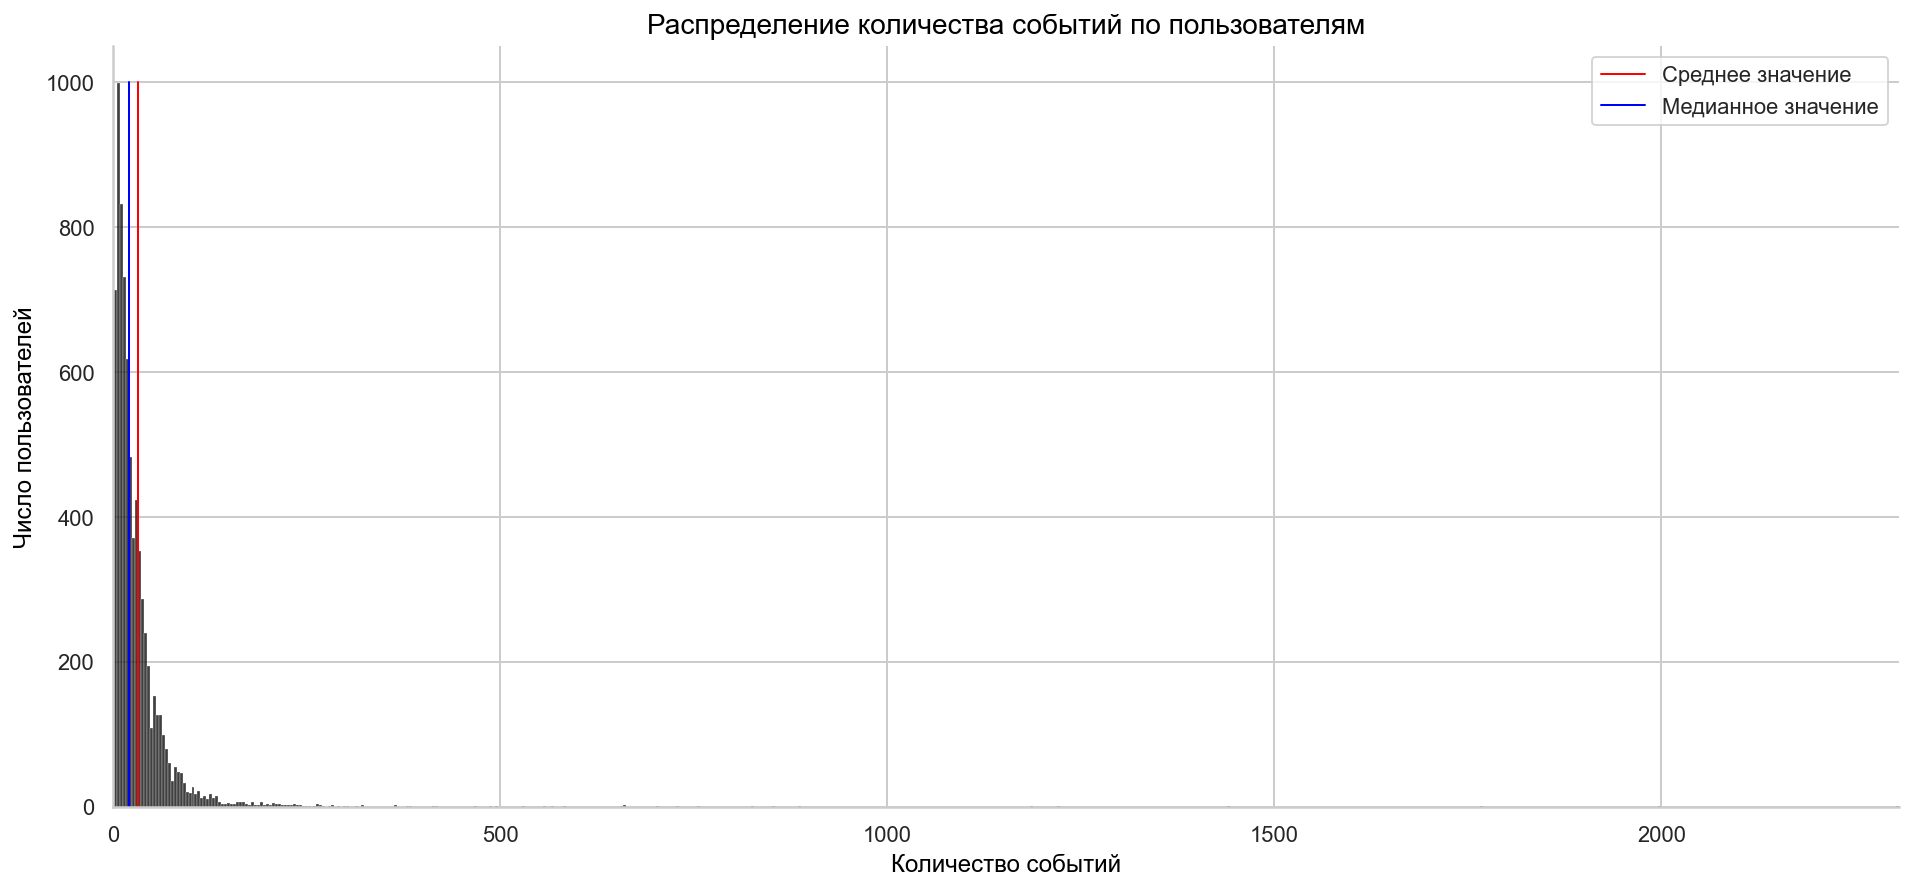

In [10]:
df_events_per_user = (
    df.groupby('user_id')
      .agg({'event': 'count'})
      .sort_values(by='event', ascending=False)
)

plt.figure(figsize=(16,7))
plt.plot([df_events_per_user.event.mean(), df_events_per_user.event.mean()], [0, 1000]
         , linewidth=1
         , color='red'
         , label='Среднее значение')
plt.plot([df_events_per_user.event.median(), df_events_per_user.event.median()], [0, 1000]
         , linewidth=1
         , color='blue'
         , label='Медианное значение')
plt.legend()

sns.histplot(x='event', data=df_events_per_user, bins=600, color = 'black').set_xlim(0,df_events_per_user.event.max())
plt.xlabel('Количество событий', color='black', size=12)
plt.ylabel('Число пользователей', color='black', size=12)

# plt.xticks(date_range, rotation=25)
plt.title('Распределение количества событий по пользователям', color='black', size=14)
plt.show()

Text(0.5, 1.0, 'Распределение количества событий по пользователям')

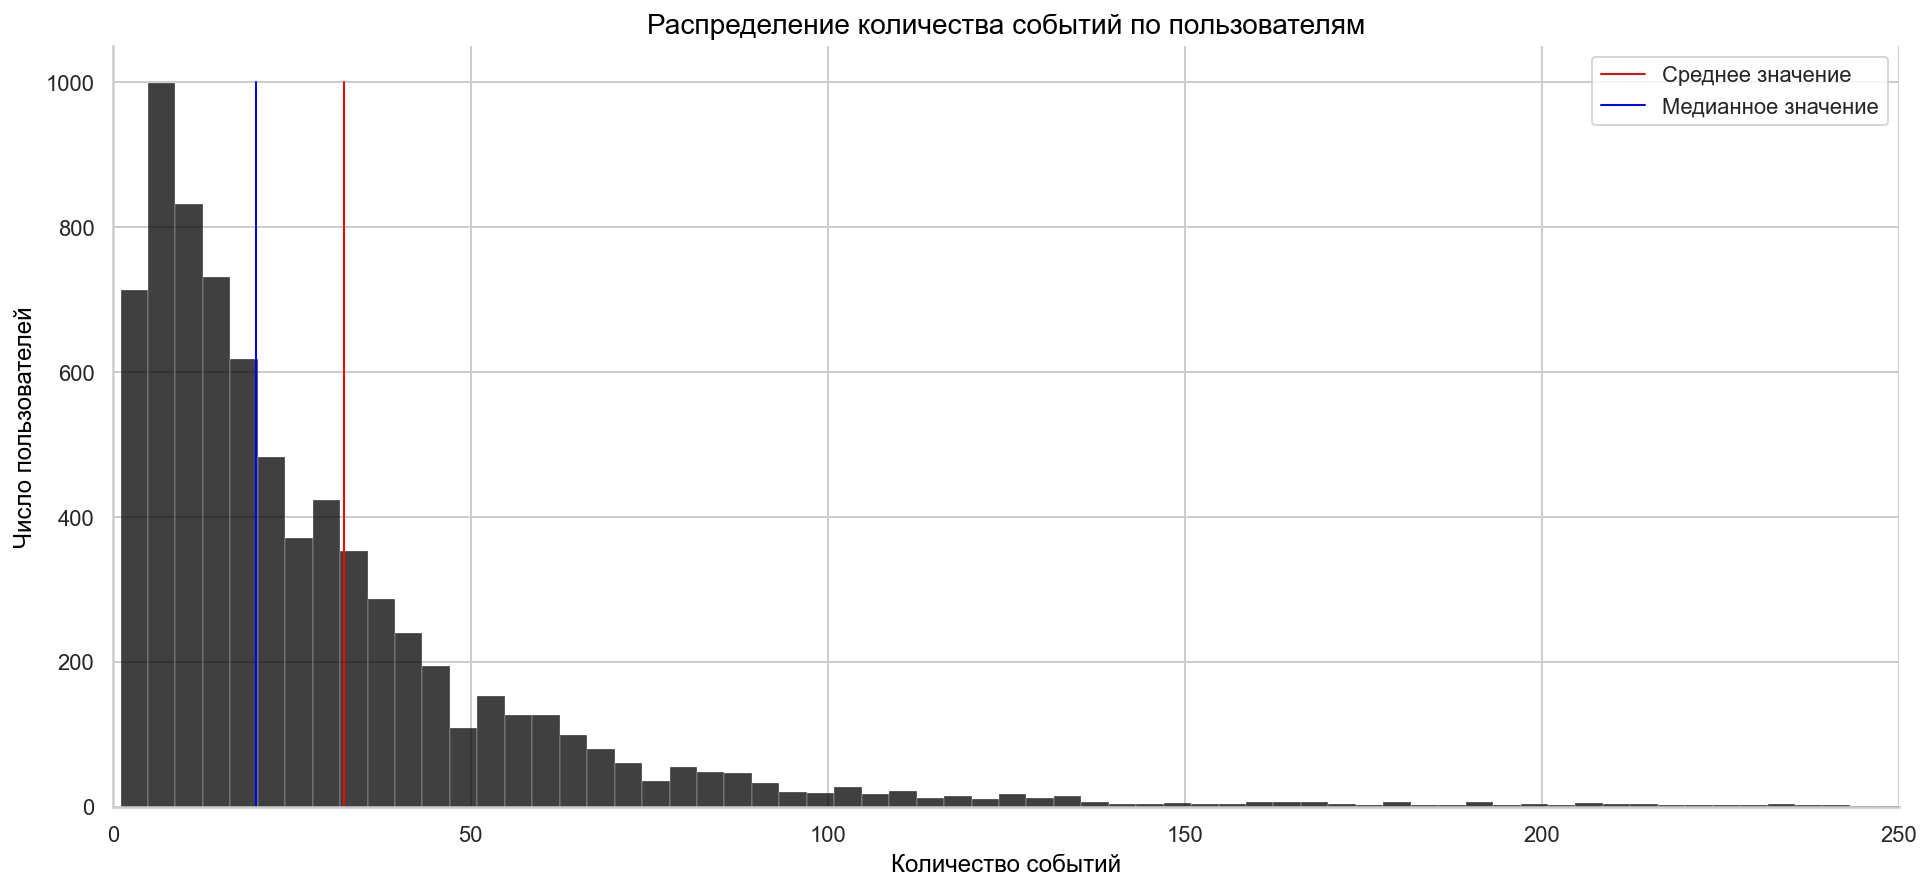

In [11]:
# посмотрим на распределение без аномально больших значений
df_events_per_user = (
    df.groupby('user_id')
      .agg({'event': 'count'})
      .sort_values(by='event', ascending=False)
)

plt.figure(figsize=(16,7))
plt.plot([df_events_per_user.event.mean(), df_events_per_user.event.mean()], [0, 1000]
         , linewidth=1
         , color='red'
         , label='Cреднее значение')
plt.plot([df_events_per_user.event.median(), df_events_per_user.event.median()], [0, 1000]
         , linewidth=1
         , color='blue'
         , label='Медианное значение')
plt.legend()
sns.histplot(x='event', data=df_events_per_user, bins=600, color = 'black').set_xlim(0,250)
plt.xlabel('Количество событий', color='black', size=12)
plt.ylabel('Число пользователей', color='black', size=12)


plt.title('Распределение количества событий по пользователям', color='black', size=14)

### Определим период за который отражены данные в логе

In [12]:
# получим сводную по группам с мин, макс и разницей в днях столбцами
tab = df.groupby('group').agg({'dt':'min'}).reset_index().merge(df.groupby('group').agg({'dt':'max'}).reset_index()
    ,left_on=['group'], right_on=['group'])
tab.columns = ['group', 'min', 'max']
print("\033[34m\033[1m{}\033[0m"
      .format(
          """   Таблица min и max дат    
   данных в разрезе групп   """))
display(tab)
print("""Данные в логе отражены за период с {} по {}

В группах данные представлены:
"""
      .format(df['dt'].min()
              ,df['dt'].max()))

for i in range(len(tab)):
    print('В {} группе за период с {} по {}.'
      .format(tab.iloc[i,0]
          ,tab.iloc[i,1]
          ,tab.iloc[i,2]))

   Таблица min и max дат    
   данных в разрезе групп   


,group,min,max
0,246,2019-07-25,2019-08-07
1,247,2019-07-25,2019-08-07
2,248,2019-07-25,2019-08-07


Данные в логе отражены за период с 2019-07-25 по 2019-08-07

В группах данные представлены:

В 246 группе за период с 2019-07-25 по 2019-08-07.
В 247 группе за период с 2019-07-25 по 2019-08-07.
В 248 группе за период с 2019-07-25 по 2019-08-07.


In [13]:
t = df.groupby('dt').agg({'user_id':'count'}).reset_index().sort_values('dt',ascending=True)
t['share'] = t['user_id']/t['user_id'].sum()*100
print("\033[34m\033[1m{}\033[0m"
      .format("""    Таблица распределения    
событий по датам и их доля   """))
display(t)

    Таблица распределения    
событий по датам и их доля   


,dt,user_id,share
0,2019-07-25,9,0.003693
1,2019-07-26,31,0.012720
2,2019-07-27,55,0.022568
3,2019-07-28,105,0.043083
4,2019-07-29,184,0.075499
5,2019-07-30,412,0.169051
6,2019-07-31,2030,0.832947
7,2019-08-01,36141,14.829328
8,2019-08-02,35554,14.588471
9,2019-08-03,33282,13.656227


Text(0.5, 1.0, 'Распределение количества событий по по часам')

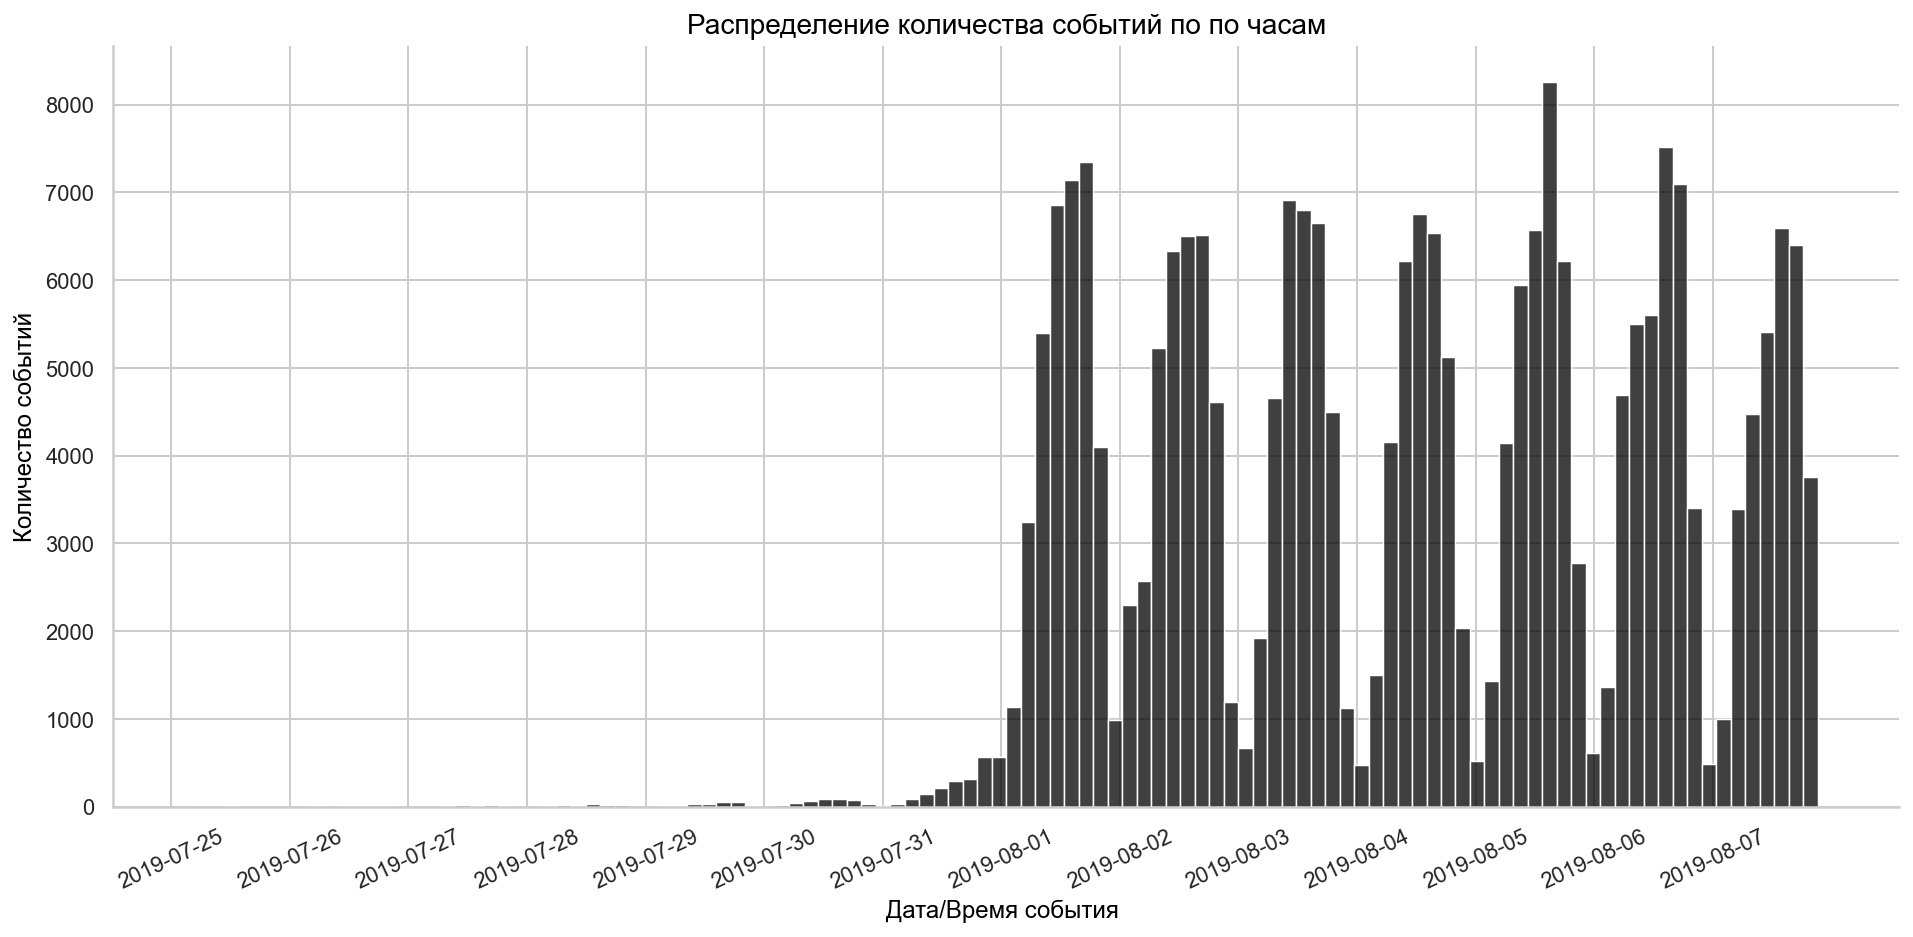

In [15]:
plt.figure(figsize=(16,7))
date_from = pd.to_datetime(df.dt).dt.date.min()
date_to = pd.to_datetime(df.dt).dt.date.max()
date_range = pd.date_range(date_from, date_to, freq="D")
sns.histplot(x='dtt', data=df, bins=24//3*14, color = 'black')
plt.xlabel('Дата/Время события ', color='black', size=12)
plt.ylabel('Количество событий', color='black', size=12)
plt.xticks(date_range, rotation=25)
plt.title('Распределение количества событий по по часам', color='black', size=14)

Данные предоставленные в логах за период с 2019-07-25 по 2019-07-31.
В этот период имеют очень низкие показатели активности пользователей т.е. количество событий, что может говорить нам о том, что данные по некоторым пользователям в указанный период «доезжают» из прошлого. 
Так же заметны пики наибольшего количества событий и в основной массе они происходят с 9:00 до 21:00.
Есть пользователи с аномально большим количеством событий так по 46 пользователям зафиксимровано более 250 событий из которых 9 более 800, а максимальное количество событий по пользователю 6304868067479728361 - 2307 событий.

Можно определить, что данные в логах предоставлены за период с 2019-08-01 по с 2019-08-01 и для того что-бы анализ был корректный, необходимо сделать срез данных без учетам данных за период с 2019-07-25 по 2019-07-31, а пользователей с большим количством событий примим как данность.

In [16]:
# создадим новый датафрейм без учета периода 2019-07-25 - 2019-07-31 
dff=df.query('dtt >= "2019-08-01"')
# сравним данные до и после среза по дате
print("""
Общее количество:
- событий до удаления {} шт.
- уникальных пользователей до удаления {} шт.\n
Необходимо удалить:
- событий {} шт. т.е. {:.2%}
- уникальных пользователя {} т.е. {:.2%}\n
После удаление количество:
- событий {} шт.
- уникальных пользователей {} шт.
      """.format(len(df)
              ,df['user_id'].nunique()
              ,len(df.query('dtt < "2019-08-01"'))
              ,len(df.query('dtt < "2019-08-01"'))/len(df)
              ,(df['user_id'].nunique() - dff['user_id'].nunique())
              ,(df['user_id'].nunique() - dff['user_id'].nunique())/df['user_id'].nunique()
              ,len(dff)
              ,dff['user_id'].nunique()))


# провеверим, что в трех группах А/А/В есть пользователи
tab = dff.groupby('group').agg({'user_id':'nunique'}).reset_index().merge(
dff.groupby('group').agg({'user_id':'count'}).reset_index(),left_on=['group'], right_on=['group'])
tab.columns = ['group','uniq_id','events']
tab['share_uniq_id'] = tab['uniq_id']/tab['uniq_id'].sum()
tab['share_event'] = tab['events']/tab['events'].sum()
print("\033[34m\033[1m{}\033[0m".format("""
     Таблица распределения по группам       
     уникальных пользователей и их доля"""))
display(tab.style.format({'share_uniq_id': '{:.0%}','share_event': '{:.0%}'}))

print('В группе:')
for i in range(len(tab)):
    print("""{}: {} уникальных пользователя ({:.0%}) и {} события ({:.0%})."""
          .format(tab.iloc[i,0]
                  ,tab.iloc[i,1]
                  ,tab.iloc[i,3]
                  ,tab.iloc[i,2]
                  ,tab.iloc[i,4]))


Общее количество:
- событий до удаления 243713 шт.
- уникальных пользователей до удаления 7551 шт.

Необходимо удалить:
- событий 2826 шт. т.е. 1.16%
- уникальных пользователя 17 т.е. 0.23%

После удаление количество:
- событий 240887 шт.
- уникальных пользователей 7534 шт.
      

     Таблица распределения по группам       
     уникальных пользователей и их доля


,group,uniq_id,events,share_uniq_id,share_event
0,246,2484,79302,33%,33%
1,247,2513,77022,33%,32%
2,248,2537,84563,34%,35%


В группе:
246: 2484 уникальных пользователя (33%) и 79302 события (33%).
247: 2513 уникальных пользователя (33%) и 77022 события (32%).
248: 2537 уникальных пользователя (34%) и 84563 события (35%).


После удаления данных ранее даты 2019-08-01, во всех 3-х группах есть пользователи. 

Уникальное количество пользователей в группах и совершенные ими действия соизмеримы.

Так же для информации:
- есть пользователи которые выполняли очень большое количество действий при этом пропускали многие другие действия, которые по логике должны идти друг за другом
- выявлены пользователи которые делали всего 1 действие, например прочитав/изучив tutorial больше не выполняли никаких действий;
- выявлены пользователи разные события по которым совершались в одно время вплоть до секунды, так же нужно выяснить этот факт.


Поэтому нужно уточниться у ответвественных за данные, может ли быть такое или нет;

## Воронка событий

### Изучим, какие события есть в логах, как часто они встречаются.

In [17]:
events = dff.groupby('event').agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)
events.columns = ['event','freq']
events['share'] = events['freq']/events['freq'].sum()

print("\033[34m\033[1m{}\033[0m".format("""    
      Таблица частосты событий     """))
display(events.style.format({'share': '{:.1%}'}))

    
      Таблица частосты событий     


,event,freq,share
1,MainScreenAppear,117328,48.7%
2,OffersScreenAppear,46333,19.2%
0,CartScreenAppear,42303,17.6%
3,PaymentScreenSuccessful,33918,14.1%
4,Tutorial,1005,0.4%


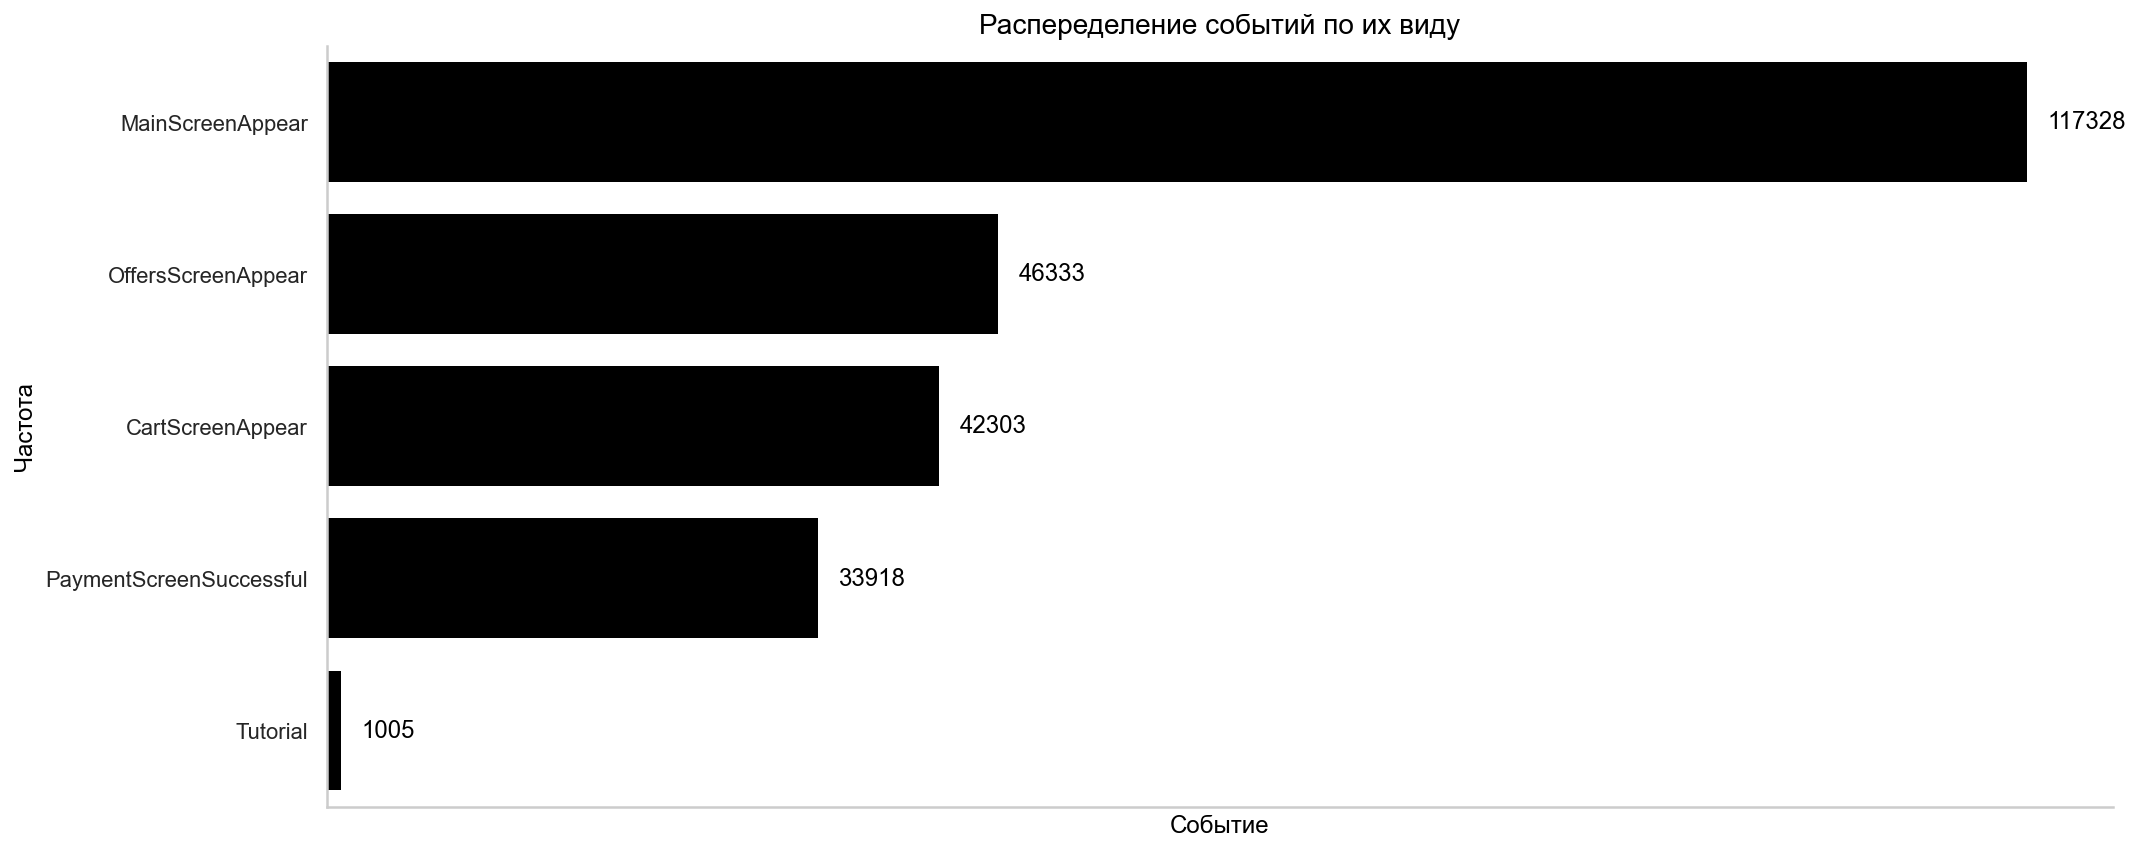

In [18]:
plt.figure(figsize=(16,7))
sns.barplot(
    y='event',
    x='freq',
    data=events,
    orient='h',
    color='black')
plt.xlabel('Событие', color='black', size=12)
plt.ylabel('Частота', color='black', size=12)
plt.xticks([])
plt.title('Распеределение событий по их виду', color='black', size=14)

for y,x in enumerate(events['freq']):
    label = format(x)
    plt.annotate(label, # текст метки
                 (x,y), # координаты метки
                 textcoords="offset points", # позиция текста метки
                 xytext=(10,0), # расстояние между текстом и точкой координат метки
                 va='center', color ='black', size=12) # выравнивание метки
plt.show()

- Самым популярным событием является появление главного экран (MainScreenAppear) - 48%, оно и логично, что практически все пользователи при входе в приложение попадают на главный экран.
- далее идут события такие как:
    - появление экрана предложения 19% (OffersScreenAppear);
    - появление экрана корзины 17% (CartScreenAppear);
    - появление экрана "оплата выполнеена успешно" 14% (PaymentScreenSuccessful)
данные события являются приблизительно одинаковыми по количеству.
- наименее популярным явлвяется событие "Руководство" менее 1% (Tutorial) т.е. практически никто не изучает так сказать техническую документацию и возможно данное событие можно исключить из расчета.

### Посчитаем, сколько пользователей совершали каждое событие и определим долю пользователей, которые хоть раз совершали событие.

In [19]:
events = dff.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)
events.columns = ['event','cnt_unique_id']
events['share_for_one_event'] = events['cnt_unique_id']/dff['user_id'].nunique()

print("\033[34m\033[1m{}\033[0m".format("""
Таблица кол-ва пользователей по событиям и их доля
   к общему кол-ву совершивших хоть 1 событие\n
* количество уникальных пользователей для расчета {}""".format(dff['user_id'].nunique())))
display(events.style.format({'share_for_one_event': '{:.1%}'}))


Таблица кол-ва пользователей по событиям и их доля
   к общему кол-ву совершивших хоть 1 событие

* количество уникальных пользователей для расчета 7534


,event,cnt_unique_id,share_for_one_event
1,MainScreenAppear,7419,98.5%
2,OffersScreenAppear,4593,61.0%
0,CartScreenAppear,3734,49.6%
3,PaymentScreenSuccessful,3539,47.0%
4,Tutorial,840,11.1%


Как и ранее наибольшее кол-во пользователей попадают на главный экран, но не 100% т.е. есть такие пользователи которые миновали это событие, что снова может говорить нам о том, что не все события выполняются поэтапно, возможно переход по прямым ссылкам в корзину или сразу к оплате, данный факт нужно уточнять и ответственных лиц за выгрузку и отслеживания событий.

### Посчитаем и изучим  воронку

Предположим что порядок событий именно такой:
- MainScreenAppear	
- OffersScreenAppear	
- CartScreenAppear
- PaymentScreenSuccessful	
а события с типом tutorial т.е. если мы правильно понимаем это событие является руководством по использованию приложения и думаю оно должно стоять как минимум 2-ым после появления главного экрана или 1-ым при скачивании приложения, но количество говорит нам об обратном, поэтому исключим данные по этим событиям для изучения воронки.


Так как мы не владеем информацией о ТОЧНОМ порядке событий в приложении, а так же возможностью пропускать события или выполнять их через одно и уточнить не предоставляется возможным, то можно сделать несколько вариантов расчета воронки событий, но впри этом Событие которое объеденяет является Main Screen Appear:
1. "Жесткий" - все пользователи текущего события должны обязательно быть в предыдущем, при таком подходе мы отсечем всех пользователей который могли получить прямые ссылки на оплату, ранее отлодженых товаров или которые увидили спецпредложение где есть кнопка купить в один клие ии т.д.
2. "Мягкий" - все пользователи могут начинать с любого события, но обязательно должны иметь событие MainScreenAppear.

Далее мы будем расчитвыть воронку событий для варианта 2 "Мягкий", когда все пользователи начинают свой путь с Main Screen Appear и далее могут пропускать некоторые события.

In [21]:
# создадим таблицу 
# users_list = dff.query('event == "MainScreenAppear"')['user_id'].unique()
tab = dff.query('event != "Tutorial"') #user_id in @users_list and 
tabl = tab.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)

tabl.columns = ['event','uniq_user']
tabl['conversion_for_step'] = tabl['uniq_user']/tabl['uniq_user'].shift(1, fill_value=tabl.uniq_user.max())
tabl['conversion_for_first_step'] = tabl['uniq_user']/tabl['uniq_user'].max()
print("\033[34m\033[1m{}\033[0m".format("""
                     Таблица расчета воронки """))
display(tabl.style.format({'conversion_for_step': '{:.1%}', 'conversion_for_first_step': '{:.1%}'}))

#построим график
arr =  ["от текущего события к предыдущему", 
       "value+percent previous",
       "текущее событие к MainScreenAppear",
       "value+percent initial"]
fig = go.Figure()
fig.add_trace(go.Funnel(
    orientation = "h",
    name = arr[0],
    y = tabl['event'],
    x = tabl['uniq_user'],
    textposition = "inside",
    textinfo = arr[1]))
fig.add_trace(go.Funnel(
    orientation = "h",
    name = arr[2],
    y = tabl['event'],
    x = tabl['uniq_user'],
    textposition = "inside",
    textinfo = arr[3]))  
fig.update_layout(title='Воронка событий',
                  yaxis_title= "",
                  xaxis_title='',height=600, width=900,plot_bgcolor='rgba(0,0,0,0)') 
fig.update_yaxes()
fig.data[0].marker.color = 'black'
fig.data[1].marker.color = 'green'
fig.show()


                     Таблица расчета воронки 


,event,uniq_user,conversion_for_step,conversion_for_first_step
1,MainScreenAppear,7419,100.0%,100.0%
2,OffersScreenAppear,4593,61.9%,61.9%
0,CartScreenAppear,3734,81.3%,50.3%
3,PaymentScreenSuccessful,3539,94.8%,47.7%


Как видно по данным воронок:
- околок 38% пользователей не доходят даже до экрана предложений, т.е. это может говорить нам о том, что есть какие-то пробелмы и возможно технические, можно предположить что новые шрифты некорректно отражаются у пользоватлей и они просто не могут пользоваться приложением и примерно такое количество пользователей 35% у нас попало в эксперементальную группу где используются новые шрифты(далее проверим коверсии по события в разрезе каждой из групп).
- около 20% пользователей отсекается после шага показа экрана предложения и перехода в корзину или 50% если брать от показа главного экрана, но опять же это может быть связано как с тех.проблемой так и с тем что пользователь может пропустить одно из событий.
- около 95% увидивших корзину переходят и оплачивают и 48% если брать от показа главного экрана.

Можно сказать что есть проблема с конверсией от показа главного экрана как минимум там мы теряем почти 40% потенциальных пользователей которые могут совершить покупку, нужно разобратсья с тем, что видят пользователи эксперементальной группы, а так же выяснить нет ли технических проблем, так же можно обратить внимание на конверсию от экрана с предложением и переходом в корзину там теряется около 19% (12%)

In [22]:
# создадми таблицу с событиями и количеством уникальных юзеров совершивших его
users_list = dff.query('event == "MainScreenAppear"')['user_id'].unique()

t_246 = dff.query('event != "Tutorial"').query('group == 246').groupby(['event']).agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)
t_247 = dff.query('event != "Tutorial"').query('group == 247').groupby(['event']).agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)
t_248 = dff.query('event != "Tutorial"').query('group == 248').groupby(['event']).agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)
t = t_246.merge(t_247,left_on='event',right_on='event').merge(t_248,left_on='event',right_on='event')
t.columns = ['event','246_users','247_users','248_users']

# построим график
fig = go.Figure()
fig.add_trace(go.Funnel(
    orientation = "h",
    name = '246 группа',
    y = t['event'],
    x = t['246_users'],
    textposition = "inside",
    textinfo = 'value+percent initial+percent previous'))
fig.add_trace(go.Funnel(
    orientation = "h",
    name = '247 группа',
    y = t['event'],
    x = t['247_users'],
    textposition = "inside",
    textinfo = 'value+percent initial+percent previous'))
fig.add_trace(go.Funnel(
    orientation = "h",
    name = '248 группа',
    y = t['event'],
    x = t['248_users'],
    textposition = "inside",
    textinfo = 'value+percent initial+percent previous'))  
fig.update_layout(title='Воронка событий по группам (процент конверсии от текущего события к предыдущему)',
                  yaxis_title= "",
                  xaxis_title='',height=600, width=900,plot_bgcolor='rgba(0,0,0,0)') 
fig.update_yaxes()
fig.data[0].marker.color = 'black'
fig.data[1].marker.color = 'green'
fig.data[2].marker.color = 'blue'
fig.show()


Как мы видим данные воронок по группам так же примерно одинаковы и причина отсутствия коверсии из показа главного экрана к предложениям остается открытой, при этом если предположить, что экран с предложением можно пропускать, тогда так же нужно разобраться с проблемами экрана предложений и конверсией главного экрана к показу к корзине, так как порядка 95% и 45% пользователей совершают покупку после того как произойдет появление экрана корзины.

Около 46% пользователей проходят от первого до последнего события.

## Проверка результатов экспиримента (А/А/В экспиримент)

### Расчитаем количество пользователей в каждой экспериментальной группе в разрезе каждого события

In [23]:
pt = pd.pivot_table(dff,index='group', values='user_id',columns='event', aggfunc='nunique').reset_index().sort_values('group')
pt = pt.merge(pd.pivot_table(dff,index='group', values='user_id', aggfunc='nunique').reset_index().sort_values('group').rename(columns={'user_id':'total'})
              ,left_on = 'group'
              ,right_on ='group')

row_246_247= {'group':'246+247'
              , 'CartScreenAppear':pt.iloc[0,1]+pt.iloc[1,1]
              ,'MainScreenAppear':pt.iloc[0,2]+pt.iloc[1,2]
              ,'OffersScreenAppear':pt.iloc[0,3]+pt.iloc[1,3]
              ,'PaymentScreenSuccessful':pt.iloc[0,4]+pt.iloc[1,4]
              ,'Tutorial':pt.iloc[0,5]+pt.iloc[1,5]
              ,'total':pt.iloc[0,6]+pt.iloc[1,6]}
pt = pt.append(row_246_247,ignore_index=True)
pt = pt.set_index(["group"], drop=True)
print("\033[34m\033[1m{}\033[0m".format("""    
                  Таблица количества уникальных пользователей 
                     по группам в разрезе каждого событиям"""))
display(pt)

print('Уникальных пользователей в экспериментальной группе:')
for i in pt.index:

    print('№ {} - {} шт.'.format(i,pt.loc[i]["total"], pt.loc[i]["total"]))

    
                  Таблица количества уникальных пользователей 
                     по группам в разрезе каждого событиям


,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
group,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537
246+247,2504,4926,3062,2358,561,4997


Уникальных пользователей в экспериментальной группе:
№ 246 - 2484 шт.
№ 247 - 2513 шт.
№ 248 - 2537 шт.
№ 246+247 - 4997 шт.


Из полученных данных видно, что количество пользователей прмерно одинаково как в общем по группе так и в разрезе каждого события.

###  Проверим, находят ли статистические критерии разницу между выборками 246 и 247. (А/А тест)

In [24]:
# Для проверки гипотезы о равенстве долей 
# напишем функцию, которая определит есть статически значимые различаи между долям выборок
def st_test(test0, test1, total0, total1):
    alpha = 0.05 # задаем уровень статистической значимости
    p1 = test0 / total0 # считаем пропорцию успехов в первой группе
    p2 = test1 / total1 # считаем пропорцию успехов во второй группе
    p_combined = (test0 + test1) / (total0 + total1) # считаем пропорция успехов в комбинированном датасете
    difference = p1 - p2 # считаем разницу пропорций в датасетах
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1)) # считаем статистику в стандартных отклонениях стандартного нормального распределения
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ста.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return  alpha, round(p_value,5)

Что бы снизить групповую вероятность ошибки первого рода при множественном тестировании гипотез, применим Метод Шидака корректировки уровня значимости для ее уменьшения.

Скорректированное значение требуемого уровня значимости рассчитывается по формуле:

$$ alpha_{1}=alpha_{2}=...=alpha_{m}=1-(1-alpha) ^ 1_{m} $$

In [25]:
k=0
print("""
Проверим есть ли между контрольными группами 246 и 247 
статически значимые различия между долями пользователей совершивших событие:\n""")
print("*"*90)
for col in ['MainScreenAppear'
            , 'OffersScreenAppear'
            , 'CartScreenAppear'
            , 'PaymentScreenSuccessful']:
    k+=1
    alpha, p_value = st_test(pt.loc[246][col]
                        ,pt.loc[247][col]
                        ,pt.loc[246]['total']
                        ,pt.loc[247]['total'])
    print("-"*90)
    alpha_shidaka = round(1-(1-alpha)**(1/k),5)
    print("""    \033[34m{}. {}\033[0m""".format(k,col))
    print("""
    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие {} разницы нет.
    H1:  Между долями пользователей совершивших событие {} разница есть.""".format(col,col))
    print("""
    p_value: {}
    alpha: {}
    alpha_shidaka: {}""".format(p_value, alpha,alpha_shidaka))
    if p_value < alpha:
        print("""\033[31mРезультат: Отвергаем нулевую гипотезу: между долями есть значимая разница.\033[0m\n""")
    else:
        print("""\033[32mРезультат: Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.\033[0m\n""")


Проверим есть ли между контрольными группами 246 и 247 
статически значимые различия между долями пользователей совершивших событие:

******************************************************************************************
------------------------------------------------------------------------------------------
    1. MainScreenAppear

    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие MainScreenAppear разницы нет.
    H1:  Между долями пользователей совершивших событие MainScreenAppear разница есть.

    p_value: 0.75706
    alpha: 0.05
    alpha_shidaka: 0.05
Результат: Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

------------------------------------------------------------------------------------------
    2. OffersScreenAppear

    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие OffersScreenAppear разницы нет.
    H1:  Между долями пользователей совершивших событие OffersScreenAppe

По всем события А/А тест показал нам, что разницы между двумя контрольными выборками нет, а значит разбиние на группы работает корректно.

###  Проверим, находят ли статистические критерии разницу между экспирементальныой выборкой и контрольными (А/А/A+B/В тест)

In [25]:
for i in [246,247,'246+247']:
    
    k=0
    print("""
    Проверим есть ли между контрольной группой {} и экспирементальной - {} статически
значимые различия между долями пользователей совершивших событие:\n""".format(i,248))
    print("*"*90)
    for col in ['MainScreenAppear'
                , 'OffersScreenAppear'
                , 'CartScreenAppear'
                , 'PaymentScreenSuccessful']:
        k+=1
        alpha, p_value = st_test(pt.loc[i][col]
                            ,pt.loc[248][col]
                            ,pt.loc[i]['total']
                            ,pt.loc[248]['total'])
        print("-"*90)
        alpha_shidaka = round(1-(1-alpha)**(1/k),5)
        print("""    \033[34m{}. {}\033[0m""".format(k,col))
        print("""
    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие {} разницы нет.
    H1:  Между долями пользователей совершивших событие {} разница есть.""".format(col,col))
        print("""
    p_value: {}
    alpha: {}
    alpha_shidaka: {}
        """.format(p_value, alpha,alpha_shidaka))
        
        if p_value < alpha:
            print("""\033[31mРезультат: Отвергаем нулевую гипотезу: между долями есть значимая разница.\033[0m\n""")
        else:
            print("""\033[32mРезультат: Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.\033[0m\n""")


    Проверим есть ли между контрольной группой 246 и экспирементальной - 248 статически
значимые различия между долями пользователей совершивших событие:

******************************************************************************************
------------------------------------------------------------------------------------------
    1. MainScreenAppear

    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие MainScreenAppear разницы нет.
    H1:  Между долями пользователей совершивших событие MainScreenAppear разница есть.

    p_value: 0.29497
    alpha: 0.05
    alpha_shidaka: 0.05
        
Результат: Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

------------------------------------------------------------------------------------------
    2. OffersScreenAppear

    Формулировка гипотезы:
    H0:  Между долями пользователей совершивших событие OffersScreenAppear разницы нет.
    H1:  Между долями пользователей соверш

### Выводы:

В результате проверки гипотез был выбран уровень значимости alpha = 5%.
Было проведено 16 проверок статистических гипотез из которых 4 А/А тест В результате которых экспиремнатальная группа не показала разницу в поведении потребителей.

Полученые результаты позволяют нам сказать о том, что переживания менеджеров были напрасны и
решение дизайнеров о замене шрифтов можно запускать на всех пользователей.

Так же стоит обратить внимание что мы теряем около:
-  40% потенциальных пользователей которые после просмотра главного экрана не попадают на экран с предложением и соответсвенно не совершают покупок.
-  так же есть вероятность проблем с переходом с с экрана предложения в корзину там около 12 %, когда как те пользователи коотрые попали в корзину с 95% совершают платеж.

